In [1]:
import alminer, pandas, pymysql, time, glob, os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## What kind of galaxies did we find?

In [36]:
objID, project_code = np.loadtxt('alma_sdss_target_info.txt', unpack = True, comments = '#', usecols = [0,6], dtype = str)
angres, spatialmax = np.loadtxt('alma_sdss_target_info.txt', unpack = True, comments = '#', usecols = [4,5], dtype = float)


in_co10 = np.loadtxt('alma_sdss_target_info.txt', unpack = True, comments = '#', usecols = [7], dtype = str)
in_co10[in_co10 == 'True'] = 1 
in_co10[in_co10 == 'False'] = 0
in_co10 = np.array(in_co10, dtype = int)
in_co10 = np.array(in_co10, dtype = bool)

in_co21 = np.loadtxt('alma_sdss_target_info.txt', unpack = True, comments = '#', usecols = [8], dtype = str)
in_co21[in_co21 == 'True'] = 1 
in_co21[in_co21 == 'False'] = 0
in_co21 = np.array(in_co21, dtype = int)
in_co21 = np.array(in_co21, dtype = bool)

in_co32 = np.loadtxt('alma_sdss_target_info.txt', unpack = True, comments = '#', usecols = [9], dtype = str)
in_co32[in_co32 == 'True'] = 1 
in_co32[in_co32 == 'False'] = 0
in_co32 = np.array(in_co32, dtype = int)
in_co32 = np.array(in_co32, dtype = bool)

in_13co21 = np.loadtxt('alma_sdss_target_info.txt', unpack = True, comments = '#', usecols = [10], dtype = str)
in_13co21[in_13co21 == 'True'] = 1 
in_13co21[in_13co21 == 'False'] = 0
in_13co21 = np.array(in_co21, dtype = int)
in_13co21 = np.array(in_co21, dtype = bool)

In [3]:
print(f'There are {len(objID)} spectral windows matched to SDSS spectra.')

There are 15588 spectral windows matched to SDSS spectra.


In [4]:
print(f'There are {len(np.unique(objID))} unique SDSS objects matched to ALMA observations.')

There are 657 unique SDSS objects matched to ALMA observations.


In [5]:
print(f'There are {len(np.unique(objID[in_co10]))} unique SDSS objects matched to ALMA observations with CO(1-0).')

There are 356 unique SDSS objects matched to ALMA observations with CO(1-0).


In [6]:
#Query MySQL for CFIS tiles +
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'sdss', user = 'swilkinson', passwd = '123Sdss!@#')
x = 'SELECT u.objID, u.total_sfr_med, u.total_mass_med, u.z_spec, \
    u.new_K01_flag, u.new_K03_flag, u.agn_sn, u.delta_sfr, \
    p.selected_by_PCA, p.selected_by_goto\
    FROM dr7_uberuber u, dr7_PSB_params p\
    WHERE u.total_mass_med > 1 AND u.z_spec < 0.5 AND u.decl < 47 AND u.objID=p.objID'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()

db_data = np.array(db_data, dtype = str).T

objID_db = db_data[0]
sfr = np.array(db_data[1], dtype = float)
mass = np.array(db_data[2], dtype = float)
z = np.array(db_data[3], dtype = float)
K01 = np.array(db_data[4], dtype = str)
K03 = np.array(db_data[5], dtype = str)
agn_sn = np.array(db_data[6], dtype = str)
dsfr = np.array(db_data[7], dtype = str)
pca = np.array(db_data[8], dtype = str)
goto = np.array(db_data[9], dtype = str)

In [7]:
ssfr = np.log10(10**sfr / 10**mass)

In [8]:
match, idx, idx_db = np.intersect1d(objID[in_co10], objID_db, return_indices = True)

In [9]:
print(f'There are {len(objID_db[idx_db])} unique SDSS objects matched to ALMA observations (with CO coverage and ancillary data).')

There are 356 unique SDSS objects matched to ALMA observations (with CO coverage and ancillary data).


In [10]:
print(f'There are {len(np.unique(objID_db[idx_db]))} unique SDSS objects matched to ALMA observations (with CO coverage and ancillary data).')

There are 356 unique SDSS objects matched to ALMA observations (with CO coverage and ancillary data).


In [11]:
print(f'There are {len(objID_db[idx_db][(angres[in_co10][idx] < 3) & (spatialmax[in_co10][idx] > 6)])} unique SDSS objects matched to ALMA observations (with ancillary data and required CO(1-0) data).')

There are 307 unique SDSS objects matched to ALMA observations (with ancillary data and required CO(1-0) data).


## Distributions of ALMA properties

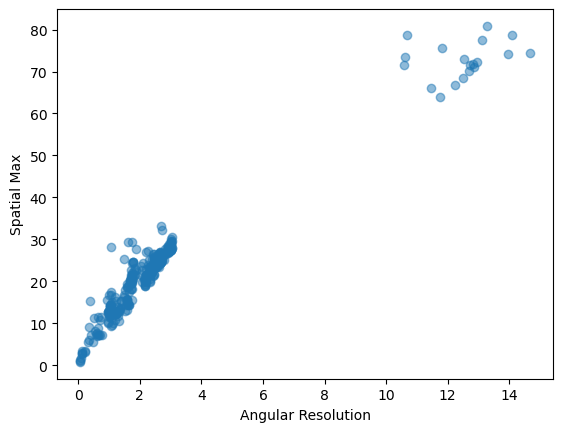

In [19]:
plt.scatter(angres[in_co10][idx], spatialmax[in_co10][idx], alpha = 0.5)
plt.xlabel('Angular Resolution')
plt.ylabel('Spatial Max')
plt.show()

## Global SFMS

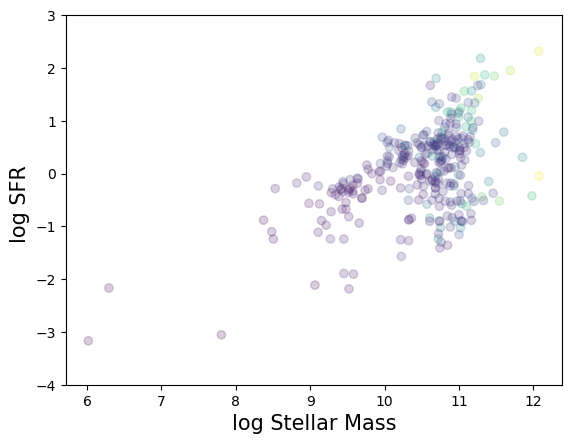

In [131]:
mask = (angres[in_co10][idx] < 3) & (spatialmax[in_co10][idx] > 6)

plt.figure()
plt.scatter(mass[idx_db][mask], sfr[idx_db][mask], alpha = 0.2, c = z[idx_db][mask] )
plt.ylim(-4,3)
plt.ylabel('log SFR ', fontsize = 15)
plt.xlabel('log Stellar Mass', fontsize = 15)
plt.show()

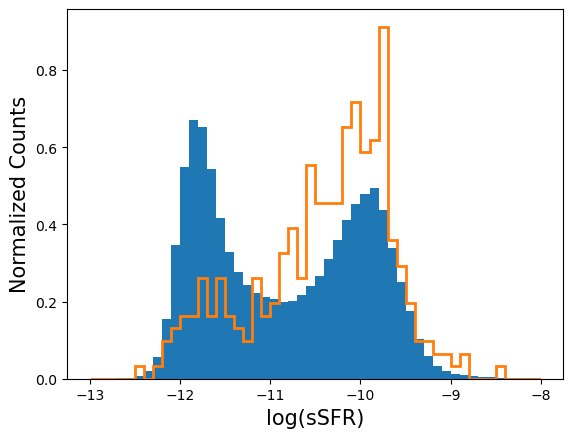

In [132]:
plt.hist(ssfr, bins = 50, range = [-13, -8], density = True, label = 'SDSS Parent Sample')
plt.hist(ssfr[idx_db][mask], bins = 50, range = [-13, -8], histtype = 'step', density = True, lw = 2, label = 'CO Observations')
plt.xlabel('log(sSFR)', fontsize = 15)
plt.ylabel('Normalized Counts', fontsize = 15)
plt.show()

In [133]:
print(f'There are {len(objID_db[idx_db][(K01[idx_db] == "AGN") & (angres[in_co10][idx] < 3) & (spatialmax[in_co10][idx] > 6)])} unique SDSS objects with CO(1-0) coverage and meet the Kewley+01 AGN criterion.')

There are 49 unique SDSS objects with CO(1-0) coverage and meet the Kewley+01 AGN criterion.


In [134]:
print(f'There are {len(objID_db[idx_db][(K03[idx_db] == "AGN") & (angres[in_co10][idx] < 3) & (spatialmax[in_co10][idx] > 6)])} unique SDSS objects with CO(1-0) coverage and meet the Kauffman+03 AGN criterion.')

There are 130 unique SDSS objects with CO(1-0) coverage and meet the Kauffman+03 AGN criterion.


In [135]:
print(f'There are {len(objID_db[idx_db][(pca[idx_db] == "1") & (angres[in_co10][idx] < 3) & (spatialmax[in_co10][idx] > 6)])} unique SDSS objects with CO(1-0) coverage and meet the PCA PSB criterion.')

There are 5 unique SDSS objects with CO(1-0) coverage and meet the PCA PSB criterion.


In [136]:
print(f'There are {len(objID_db[idx_db][(goto[idx_db] == "1") & (angres[in_co10][idx] < 3) & (spatialmax[in_co10][idx] > 6)])} unique SDSS objects with CO(1-0) coverage and meet the Goto PSB criterion.')

There are 2 unique SDSS objects with CO(1-0) coverage and meet the Goto PSB criterion.


In [20]:
print(f'There are {len(objID_db[idx_db][((goto[idx_db] == "1") | (pca[idx_db] == "1")) & (angres[in_co10][idx] < 3) & (spatialmax[in_co10][idx] > 6)])} unique SDSS objects with CO(1-0) coverage and meet the Goto or PCA PSB criterion.')

There are 5 unique SDSS objects with CO(1-0) coverage and meet the Goto or PCA PSB criterion.


In [23]:
project_code[in_co10][idx][((goto[idx_db] == "1") | (pca[idx_db] == "1")) & (angres[in_co10][idx] < 3) & (spatialmax[in_co10][idx] > 6)]

array(['2021.1.01089.S', '2016.1.00177.S', '2017.1.01727.S',
       '2019.1.01136.S', '2012.1.01080.S'], dtype='<U18')

PSB projects: SFMS (Luca Cortese), outflows, TDE, PSBs (Kate Rowlands), H-ATLAS

So 4/5 are not dedicated PSB programs. Has someone already studied them from the archive?

## Look at a subset with statmorph morphologies

In [218]:
#Query MySQL for CFIS tiles +
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'sdss', user = 'swilkinson', passwd = '123Sdss!@#')
x = 'SELECT u.objID, u.total_sfr_med, u.total_mass_med, u.z_spec, \
    u.new_K01_flag, u.new_K03_flag, u.agn_sn, u.delta_sfr, \
    p.selected_by_PCA, p.selected_by_goto, \
    s.asymmetry, s.shape_asymmetry \
    FROM dr7_uberuber u, dr7_PSB_params p, dr7_statmorph_r s\
    WHERE u.total_mass_med > 1 AND u.z_spec < 0.5 AND u.decl < 47 AND u.objID=p.objID AND u.objID=s.objID'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()

db_data = np.array(db_data, dtype = str).T

objID_db = db_data[0]
sfr = np.array(db_data[1], dtype = float)
mass = np.array(db_data[2], dtype = float)
z = np.array(db_data[3], dtype = float)
K01 = np.array(db_data[4], dtype = str)
K03 = np.array(db_data[5], dtype = str)
agn_sn = np.array(db_data[6], dtype = str)
dsfr = np.array(db_data[7], dtype = str)
pca = np.array(db_data[8], dtype = str)
goto = np.array(db_data[9], dtype = str)
A = np.array(db_data[10], dtype = float)
As = np.array(db_data[11], dtype = float)

In [219]:
ssfr = np.log10(10**sfr / 10**mass)

In [224]:
ssfr_f = np.log10(10**sfr_f / 10**mass_f)
ssfr_o = np.log10(10**sfr_o / 10**mass_o)

/tmp/ipykernel_4383/3138720132.py:1: RuntimeWarning: divide by zero encountered in divide
  ssfr_f = np.log10(10**sfr_f / 10**mass_f)


In [225]:
dssfr = 10**ssfr_o / 10**ssfr_f

In [220]:
match, idx, idx_db = np.intersect1d(objID[in_co10], objID_db, return_indices = True)

In [221]:
print(f'There are {len(objID_db[idx_db])} unique SDSS objects matched to ALMA observations (with CO coverage and ancillary data).')

There are 308 unique SDSS objects matched to ALMA observations (with CO coverage and ancillary data).


In [222]:
print(f'There are {len(objID_db[idx_db][(angres[in_co10][idx] < 3) & (spatialmax[in_co10][idx] > 6)])} unique SDSS objects matched to ALMA observations (with ancillary data and required CO(1-0) data).')

There are 263 unique SDSS objects matched to ALMA observations (with ancillary data and required CO(1-0) data).


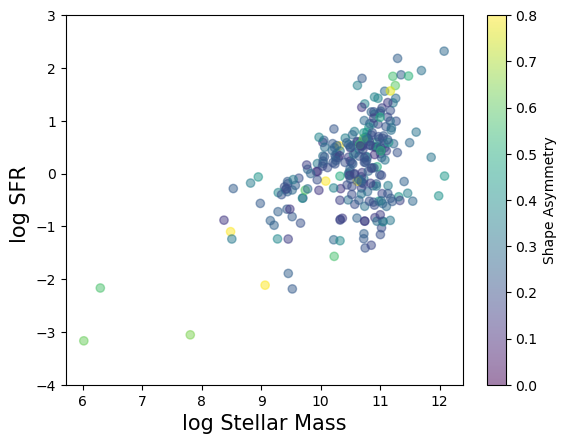

In [223]:
mask = (angres[in_co10][idx] < 3) & (spatialmax[in_co10][idx] > 6)

plt.figure()
plt.scatter(mass[idx_db][mask], sfr[idx_db][mask], alpha = 0.5, c = As[idx_db][mask], vmin = 0, vmax = 0.8)
plt.colorbar(label = 'Shape Asymmetry')
plt.ylim(-4,3)
plt.ylabel('log SFR ', fontsize = 15)
plt.xlabel('log Stellar Mass', fontsize = 15)
plt.show()

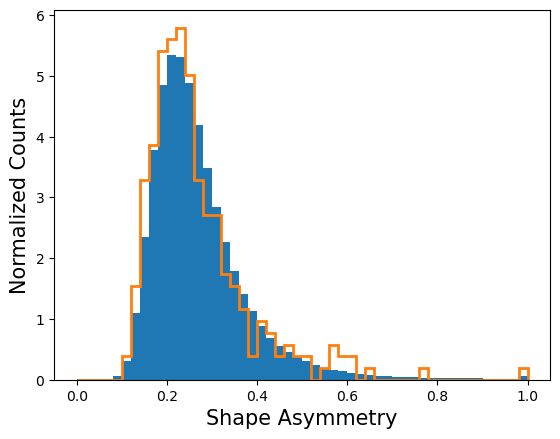

In [148]:
plt.hist(As, bins = 50, range = [0,1], density = True, label = 'SDSS Parent Sample')
plt.hist(As[idx_db][mask], bins = 50, range = [0,1], histtype = 'step', density = True, lw = 2, label = 'CO Observations')
plt.xlabel('Shape Asymmetry', fontsize = 15)
plt.ylabel('Normalized Counts', fontsize = 15)
plt.show()

In [151]:
print(f'There are {len(As_sdss[idx_db][mask][As_sdss[idx_db][mask]>0.4])} unique SDSS objects with required CO(1-0) data and are highly disturbed.')

There are 33 unique SDSS objects with required CO(1-0) data and are highly disturbed.


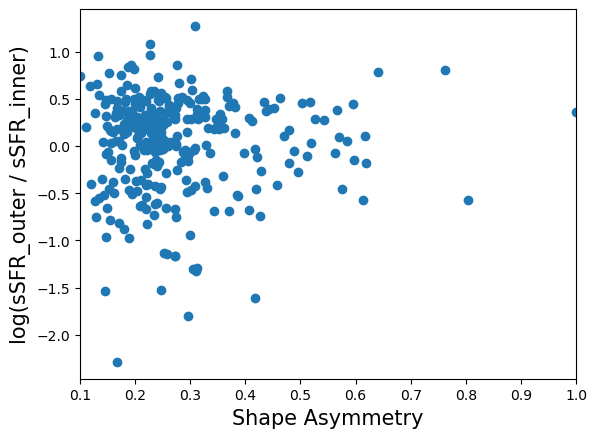

In [232]:
mask = (angres[in_co10][idx] < 3) & (spatialmax[in_co10][idx] > 6)

plt.figure()
plt.scatter(As[idx_db], np.log10(dssfr[idx_db]))
plt.ylabel('log(sSFR_outer / sSFR_inner)', fontsize = 15)
plt.xlabel('Shape Asymmetry', fontsize = 15)
plt.xlim(0.1, 1)
plt.show()

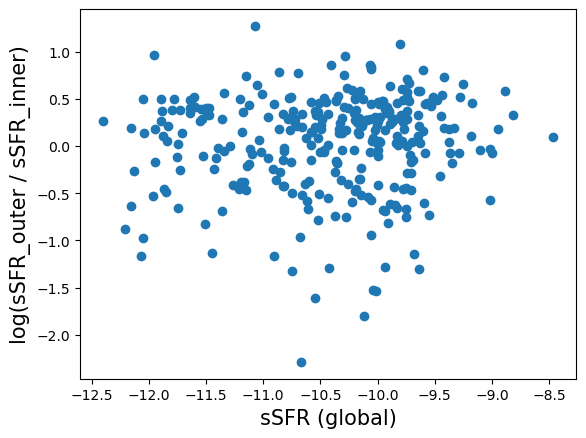

In [236]:
mask = (angres[in_co10][idx] < 3) & (spatialmax[in_co10][idx] > 6)

plt.figure()
plt.scatter(ssfr[idx_db], np.log10(dssfr[idx_db]))
plt.ylabel('log(sSFR_outer / sSFR_inner)', fontsize = 15)
plt.xlabel('sSFR (global)', fontsize = 15)
plt.show()

## Inner and Outer SFMS

In [155]:
#Query MySQL for CFIS tiles +
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'sdss', user = 'swilkinson', passwd = '123Sdss!@#')
x = 'SELECT u.objID, u.total_sfr_med, u.total_mass_med, u.z_spec, \
    u.fiber_sfr_med, u.fiber_mass_med\
    FROM dr7_uberuber u, dr7_PSB_params p\
    WHERE u.total_mass_med > 1 AND u.z_spec < 0.5 AND u.decl < 47 AND u.objID=p.objID'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()

db_data = np.array(db_data, dtype = str).T

objID_db = db_data[0]
sfr = np.array(db_data[1], dtype = float)
mass = np.array(db_data[2], dtype = float)
z = np.array(db_data[3], dtype = float)
sfr_f = np.array(db_data[4], dtype = float)
mass_f = np.array(db_data[5], dtype = float)

In [185]:
ssfr = np.log10(10**sfr / 10**mass)
ssfr_f = np.log10(10**sfr_f / 10**mass_f)
ssfr_o = np.log10(10**sfr_o / 10**mass_o)

/tmp/ipykernel_4383/1505613742.py:2: RuntimeWarning: divide by zero encountered in divide
  ssfr_f = np.log10(10**sfr_f / 10**mass_f)


In [160]:
sfr_o = np.log10(10**sfr - 10**sfr_f)
mass_o = np.log10(10**mass - 10**mass_f)

/tmp/ipykernel_4383/4009586802.py:1: RuntimeWarning: invalid value encountered in log10
  sfr_o = np.log10(10**sfr - 10**sfr_f)
/tmp/ipykernel_4383/4009586802.py:2: RuntimeWarning: invalid value encountered in log10
  mass_o = np.log10(10**mass - 10**mass_f)


In [164]:
dsfr = 10**sfr_o / 10**sfr_f
dmass = 10**mass_o / 10**mass_f

/tmp/ipykernel_4383/2225740441.py:2: RuntimeWarning: divide by zero encountered in divide
  dmass = 10**mass_o / 10**mass_f
/tmp/ipykernel_4383/2225740441.py:2: RuntimeWarning: overflow encountered in divide
  dmass = 10**mass_o / 10**mass_f


In [157]:
match, idx, idx_db = np.intersect1d(objID[in_co10], objID_db, return_indices = True)

In [158]:
print(f'There are {len(objID_db[idx_db])} unique SDSS objects matched to ALMA observations (with CO coverage and ancillary data).')

There are 356 unique SDSS objects matched to ALMA observations (with CO coverage and ancillary data).


In [159]:
print(f'There are {len(objID_db[idx_db][(angres[in_co10][idx] < 3) & (spatialmax[in_co10][idx] > 6)])} unique SDSS objects matched to ALMA observations (with ancillary data and required CO(1-0) data).')

There are 307 unique SDSS objects matched to ALMA observations (with ancillary data and required CO(1-0) data).


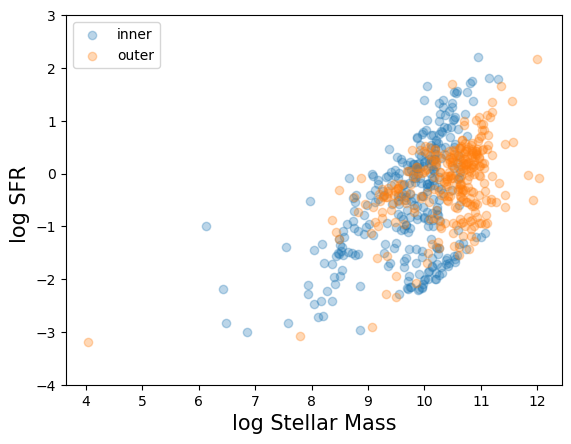

In [180]:
mask = (angres[in_co10][idx] < 3) & (spatialmax[in_co10][idx] > 6)

plt.figure()
#plt.scatter(mass[idx_db][mask], sfr[idx_db][mask], alpha = 0.3, label = 'total')
plt.scatter(mass_f[idx_db][mask], sfr_f[idx_db][mask], alpha = 0.3, label = 'inner')
plt.scatter(mass_o[idx_db][mask], sfr_o[idx_db][mask], alpha = 0.3, label = 'outer')
plt.ylim(-4,3)
plt.ylabel('log SFR ', fontsize = 15)
plt.xlabel('log Stellar Mass', fontsize = 15)
plt.legend()
plt.show()

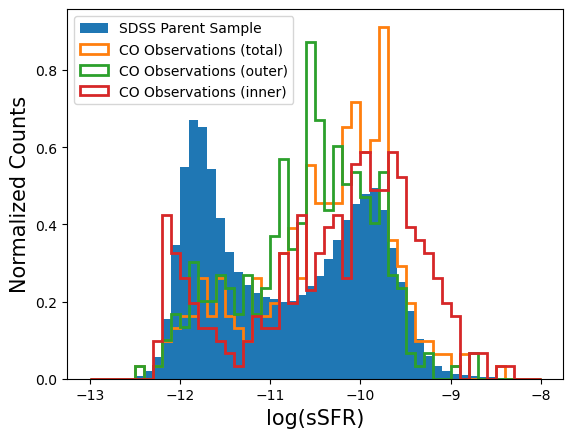

In [191]:
plt.hist(ssfr, bins = 50, range = [-13, -8], density = True, label = 'SDSS Parent Sample')
plt.hist(ssfr[idx_db][mask], bins = 50, range = [-13, -8], histtype = 'step', density = True, lw = 2, label = 'CO Observations (total)')
plt.hist(ssfr_o[idx_db][mask], bins = 50, range = [-13, -8], histtype = 'step', density = True, lw = 2, label = 'CO Observations (outer)')
plt.hist(ssfr_f[idx_db][mask], bins = 50, range = [-13, -8], histtype = 'step', density = True, lw = 2, label = 'CO Observations (inner)')
plt.xlabel('log(sSFR)', fontsize = 15)
plt.ylabel('Normalized Counts', fontsize = 15)
plt.legend()
plt.show()

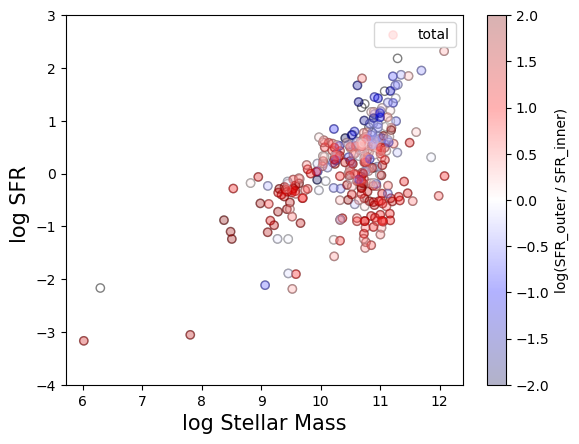

In [189]:
mask = (angres[in_co10][idx] < 3) & (spatialmax[in_co10][idx] > 6)

plt.figure()
plt.scatter(mass[idx_db][mask], sfr[idx_db][mask], alpha = 0.5, marker = 'o', facecolor = 'none', color = 'k')
plt.scatter(mass[idx_db][mask], sfr[idx_db][mask], alpha = 0.3, label = 'total', c = np.log10(dsfr[idx_db][mask]), cmap = 'seismic', vmin = -2, vmax = 2)
#plt.scatter(mass_f[idx_db][mask], sfr_f[idx_db][mask], alpha = 0.3, label = 'inner')
#plt.scatter(mass_o[idx_db][mask], sfr_o[idx_db][mask], alpha = 0.3, label = 'outer')
plt.ylim(-4,3)
plt.ylabel('log SFR ', fontsize = 15)
plt.xlabel('log Stellar Mass', fontsize = 15)
plt.legend()
plt.colorbar(label = 'log(SFR_outer / SFR_inner)')
plt.show()

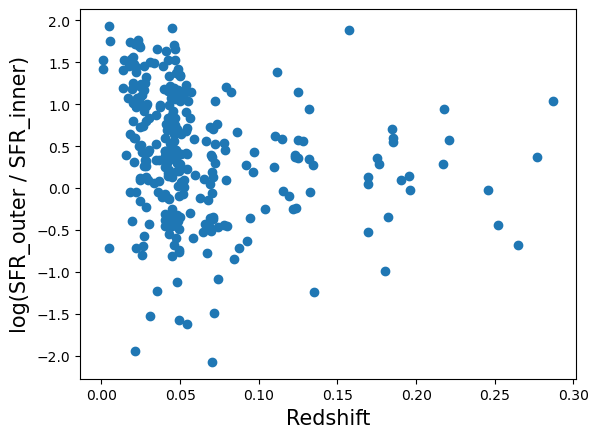

In [194]:
plt.scatter(z[idx_db][mask], np.log10(dsfr[idx_db][mask]))
plt.ylabel('log(SFR_outer / SFR_inner)', fontsize = 15)
plt.xlabel('Redshift', fontsize = 15)
plt.show()

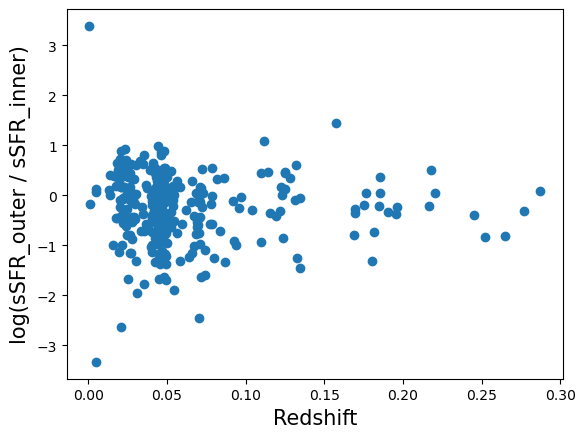

In [196]:
plt.scatter(z[idx_db][mask], np.log10(dssfr[idx_db][mask]))
plt.ylabel('log(sSFR_outer / sSFR_inner)', fontsize = 15)
plt.xlabel('Redshift', fontsize = 15)
plt.show()

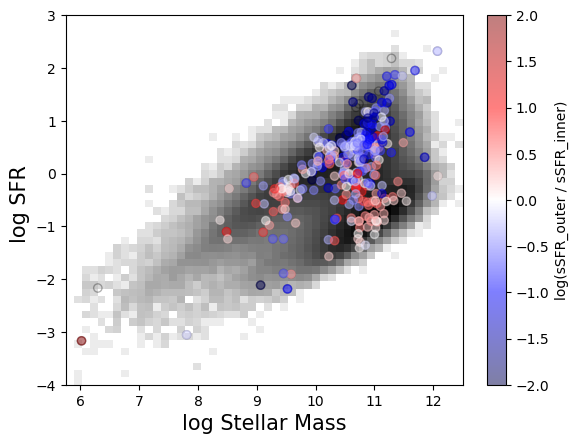

In [206]:
mask = (angres[in_co10][idx] < 3) & (spatialmax[in_co10][idx] > 6)

plt.figure()
plt.hist2d(mass, sfr, bins = 50, range = [[5.75,12.5],[-4,3]], cmap = 'gray_r', norm = 'log')
plt.scatter(mass[idx_db][mask], sfr[idx_db][mask], alpha = 0.3, marker = 'o', facecolor = 'none', color = 'k')
plt.scatter(mass[idx_db][mask], sfr[idx_db][mask], alpha = 0.5, label = 'total', c = np.log10(dssfr[idx_db][mask]), cmap = 'seismic', vmin = -2, vmax = 2)
#plt.scatter(mass_f[idx_db][mask], sfr_f[idx_db][mask], alpha = 0.3, label = 'inner')
#plt.scatter(mass_o[idx_db][mask], sfr_o[idx_db][mask], alpha = 0.3, label = 'outer')
plt.ylim(-4,3)
plt.ylabel('log SFR ', fontsize = 15)
plt.xlabel('log Stellar Mass', fontsize = 15)
#plt.legend()
plt.colorbar(label = 'log(sSFR_outer / sSFR_inner)')
plt.show()

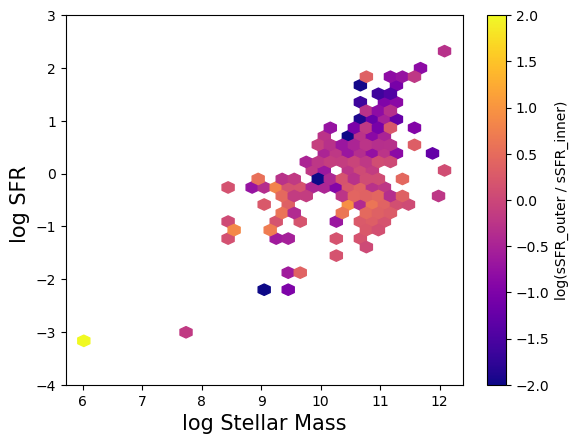

In [217]:
mask = (angres[in_co10][idx] < 3) & (spatialmax[in_co10][idx] > 6)

plt.figure()
plt.hexbin(mass[idx_db][mask], sfr[idx_db][mask], np.log10(dssfr[idx_db][mask]), cmap = 'plasma', vmin = -2, vmax = 2, gridsize = 30)
#plt.scatter(mass_f[idx_db][mask], sfr_f[idx_db][mask], alpha = 0.3, label = 'inner')
#plt.scatter(mass_o[idx_db][mask], sfr_o[idx_db][mask], alpha = 0.3, label = 'outer')
plt.ylim(-4,3)
plt.ylabel('log SFR ', fontsize = 15)
plt.xlabel('log Stellar Mass', fontsize = 15)
#plt.legend()
plt.colorbar(label = 'log(sSFR_outer / sSFR_inner)')
plt.show()

## Other line coverage

In [24]:
#Query MySQL for CFIS tiles +
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'sdss', user = 'swilkinson', passwd = '123Sdss!@#')
x = 'SELECT u.objID, u.total_sfr_med, u.total_mass_med, u.z_spec, \
    u.fiber_sfr_med, u.fiber_mass_med\
    FROM dr7_uberuber u, dr7_PSB_params p\
    WHERE u.total_mass_med > 1 AND u.z_spec < 0.5 AND u.decl < 47 AND u.objID=p.objID'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()

db_data = np.array(db_data, dtype = str).T

objID_db = db_data[0]
sfr = np.array(db_data[1], dtype = float)
mass = np.array(db_data[2], dtype = float)
z = np.array(db_data[3], dtype = float)
sfr_f = np.array(db_data[4], dtype = float)
mass_f = np.array(db_data[5], dtype = float)

In [60]:
sfr_o = np.log10(10**sfr - 10**sfr_f)
mass_o = np.log10(10**mass - 10**mass_f)

dsfr = 10**sfr_o / 10**sfr_f
dmass = 10**mass_o / 10**mass_f

ssfr = np.log10(10**sfr / 10**mass)
ssfr_f = np.log10(10**sfr_f / 10**mass_f)
ssfr_o = np.log10(10**sfr_o / 10**mass_o)

dssfr = 10**ssfr_o / 10**ssfr_f

/tmp/ipykernel_69/3930335350.py:1: RuntimeWarning: invalid value encountered in log10
  sfr_o = np.log10(10**sfr - 10**sfr_f)
/tmp/ipykernel_69/3930335350.py:2: RuntimeWarning: invalid value encountered in log10
  mass_o = np.log10(10**mass - 10**mass_f)
/tmp/ipykernel_69/3930335350.py:5: RuntimeWarning: divide by zero encountered in divide
  dmass = 10**mass_o / 10**mass_f
/tmp/ipykernel_69/3930335350.py:5: RuntimeWarning: overflow encountered in divide
  dmass = 10**mass_o / 10**mass_f
/tmp/ipykernel_69/3930335350.py:8: RuntimeWarning: divide by zero encountered in divide
  ssfr_f = np.log10(10**sfr_f / 10**mass_f)


### CO(1-0)

In [70]:
match, idx, idx_db = np.intersect1d(objID[in_co10], objID_db, return_indices = True)

In [30]:
print(f'There are {len(objID_db[idx_db])} unique SDSS objects matched to ALMA observations (with CO coverage and ancillary data).')

There are 356 unique SDSS objects matched to ALMA observations (with CO coverage and ancillary data).


In [31]:
print(f'There are {len(objID_db[idx_db][(angres[in_co10][idx] < 3) & (spatialmax[in_co10][idx] > 6)])} unique SDSS objects matched to ALMA observations (with ancillary data and required CO(1-0) data).')

There are 307 unique SDSS objects matched to ALMA observations (with ancillary data and required CO(1-0) data).


### CO(2-1)

In [37]:
match, idx, idx_db = np.intersect1d(objID[in_co21], objID_db, return_indices = True)

In [38]:
print(f'There are {len(objID_db[idx_db])} unique SDSS objects matched to ALMA observations (with CO coverage and ancillary data).')

There are 158 unique SDSS objects matched to ALMA observations (with CO coverage and ancillary data).


In [39]:
print(f'There are {len(objID_db[idx_db][(angres[in_co21][idx] < 3) & (spatialmax[in_co21][idx] > 6)])} unique SDSS objects matched to ALMA observations (with ancillary data and required CO(1-0) data).')

There are 41 unique SDSS objects matched to ALMA observations (with ancillary data and required CO(1-0) data).


### CO(3-2)

In [44]:
match, idx, idx_db = np.intersect1d(objID[in_co32], objID_db, return_indices = True)

In [45]:
print(f'There are {len(objID_db[idx_db])} unique SDSS objects matched to ALMA observations (with CO coverage and ancillary data).')

There are 48 unique SDSS objects matched to ALMA observations (with CO coverage and ancillary data).


In [46]:
print(f'There are {len(objID_db[idx_db][(angres[in_co32][idx] < 3) & (spatialmax[in_co32][idx] > 6)])} unique SDSS objects matched to ALMA observations (with ancillary data and required CO(1-0) data).')

There are 29 unique SDSS objects matched to ALMA observations (with ancillary data and required CO(1-0) data).


### 13CO(2-1)

In [47]:
match, idx, idx_db = np.intersect1d(objID[in_13co21], objID_db, return_indices = True)

In [48]:
print(f'There are {len(objID_db[idx_db])} unique SDSS objects matched to ALMA observations (with CO coverage and ancillary data).')

There are 158 unique SDSS objects matched to ALMA observations (with CO coverage and ancillary data).


In [49]:
print(f'There are {len(objID_db[idx_db][(angres[in_13co21][idx] < 3) & (spatialmax[in_13co21][idx] > 6)])} unique SDSS objects matched to ALMA observations (with ancillary data and required CO(1-0) data).')

There are 41 unique SDSS objects matched to ALMA observations (with ancillary data and required CO(1-0) data).


### CO(1-0) OR CO(2-1)

In [50]:
match, idx, idx_db = np.intersect1d(objID[in_co10 | in_co21], objID_db, return_indices = True)

In [51]:
print(f'There are {len(objID_db[idx_db])} unique SDSS objects matched to ALMA observations (with CO coverage and ancillary data).')

There are 495 unique SDSS objects matched to ALMA observations (with CO coverage and ancillary data).


In [52]:
print(f'There are {len(objID_db[idx_db][(angres[in_co10 | in_co21][idx] < 3) & (spatialmax[in_co10 | in_co21][idx] > 6)])} unique SDSS objects matched to ALMA observations (with ancillary data and required CO(1-0) data).')

There are 339 unique SDSS objects matched to ALMA observations (with ancillary data and required CO(1-0) data).


### CO(1-0) OR CO(2-1) OR CO(3-2) OR 13CO(2-1)

In [53]:
match, idx, idx_db = np.intersect1d(objID[in_co10 | in_co21 | in_co32 | in_13co21], objID_db, return_indices = True)

In [54]:
print(f'There are {len(objID_db[idx_db])} unique SDSS objects matched to ALMA observations (with CO coverage and ancillary data).')

There are 505 unique SDSS objects matched to ALMA observations (with CO coverage and ancillary data).


In [55]:
print(f'There are {len(objID_db[idx_db][(angres[in_co10 | in_co21 | in_co32 | in_13co21][idx] < 3) & (spatialmax[in_co10 | in_co21 | in_co32 | in_13co21][idx] > 6)])} unique SDSS objects matched to ALMA observations (with ancillary data and required CO(1-0) data).')

There are 345 unique SDSS objects matched to ALMA observations (with ancillary data and required CO(1-0) data).


### CO(1-0) AND CO(2-1)

In [56]:
match, idx, idx_db = np.intersect1d(objID[in_co10 & in_co21], objID_db, return_indices = True)

In [57]:
print(f'There are {len(objID_db[idx_db])} unique SDSS objects matched to ALMA observations (with CO coverage and ancillary data).')

There are 0 unique SDSS objects matched to ALMA observations (with CO coverage and ancillary data).


In [58]:
print(f'There are {len(objID_db[idx_db][(angres[in_co10 & in_co21][idx] < 3) & (spatialmax[in_co10 & in_co21][idx] > 6)])} unique SDSS objects matched to ALMA observations (with ancillary data and required CO(1-0) data).')

There are 0 unique SDSS objects matched to ALMA observations (with ancillary data and required CO(1-0) data).


### Back to the SFMS with CO(1-0) OR CO(2-1)

In [63]:
match, idx, idx_db = np.intersect1d(objID[in_co10 | in_co21], objID_db, return_indices = True)

In [64]:
print(f'There are {len(objID_db[idx_db])} unique SDSS objects matched to ALMA observations (with CO coverage and ancillary data).')

There are 495 unique SDSS objects matched to ALMA observations (with CO coverage and ancillary data).


In [65]:
print(f'There are {len(objID_db[idx_db][(angres[in_co10 | in_co21][idx] < 3) & (spatialmax[in_co10 | in_co21][idx] > 6)])} unique SDSS objects matched to ALMA observations (with ancillary data and required CO(1-0) data).')

There are 339 unique SDSS objects matched to ALMA observations (with ancillary data and required CO(1-0) data).


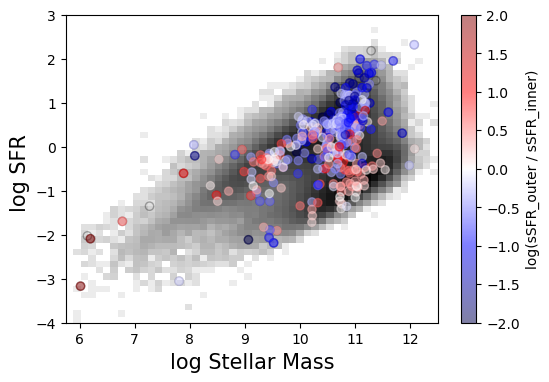

In [69]:
mask = (angres[in_co10 | in_co21][idx] < 3) & (spatialmax[in_co10 | in_co21][idx] > 6)

plt.figure(figsize = (6,4))
plt.hist2d(mass, sfr, bins = 50, range = [[5.75,12.5],[-4,3]], cmap = 'gray_r', norm = 'log')
plt.scatter(mass[idx_db][mask], sfr[idx_db][mask], alpha = 0.3, marker = 'o', facecolor = 'none', color = 'k')
plt.scatter(mass[idx_db][mask], sfr[idx_db][mask], alpha = 0.5, label = 'total', c = np.log10(dssfr[idx_db][mask]), cmap = 'seismic', vmin = -2, vmax = 2)
#plt.scatter(mass_f[idx_db][mask], sfr_f[idx_db][mask], alpha = 0.3, label = 'inner')
#plt.scatter(mass_o[idx_db][mask], sfr_o[idx_db][mask], alpha = 0.3, label = 'outer')
plt.ylim(-4,3)
plt.ylabel('log SFR ', fontsize = 15)
plt.xlabel('log Stellar Mass', fontsize = 15)
#plt.legend()
plt.colorbar(label = 'log(sSFR_outer / sSFR_inner)')
plt.show()